In [1]:
import os
seed = 0
os.environ['PYTHONHASSEED'] = str(seed)

In [2]:
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import pickle
from decimal import Decimal

from tensorflow.random import set_seed

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [4]:
# Set seed
random.seed(seed)
np.random.seed(seed)
set_seed(seed)

In [5]:
filename = '../data/turbofan_dataset/N-CMAPSS_DS02-006.h5'
output_path = 'DS02/experiment_set_5'

In [6]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [7]:
# CONSTANTS
VARIANCE_TH = 0
TEST_SET_SIZE = 0.3

In [8]:
def load_dataset(filename):
    """ Reads a dataset from a given .h5 file and compose (in memory) the train and test data. 
    Args:
        filename(str): path to the .h5 file
    Returns:
        train_set(pd.DataFrame), test_set(pd.DataFrame)
    """
    with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        columns = []
        columns += list(np.array(A_var, dtype='U20'))
        columns += list(np.array(T_var, dtype='U20'))
        columns += list(np.array(X_s_var, dtype='U20'))
        columns += list(np.array(X_v_var, dtype='U20'))
        columns += list(np.array(W_var, dtype='U20'))
        columns += ['RUL']
        
    train_set = np.concatenate((A_dev, T_dev, X_s_dev, X_v_dev, W_dev, Y_dev), axis=1)
    test_set = np.concatenate((A_test, T_test, X_s_test, X_v_test, W_test, Y_test), axis=1)
    
    return pd.DataFrame(data=train_set, columns=columns), pd.DataFrame(data=test_set, columns=columns)

In [9]:
start_time = time.process_time()  
train_set, test_set = load_dataset(filename)
print('')
print("Operation time (sec): " , (time.process_time() - start_time))
print('')
print ("Train set shape: " + str(train_set.shape))
print ("Test set shape: " + str(test_set.shape))


Operation time (sec):  3.375

Train set shape: (5263447, 47)
Test set shape: (1253743, 47)


In [10]:
def unit_cycle_info(df, compute_cycle_len=False):
    unit_ids = np.unique(df['unit'])
    print('Engine units in df: ', unit_ids)
    for i in unit_ids:
        num_cycles = len(np.unique(df.loc[df['unit'] == i, 'cycle']))
        print('Unit: ', i, ' - Number of flight cycles: ', num_cycles)
        
    if compute_cycle_len:
        cycle_ids = np.unique(df['cycle'])
        print('Total number of cycles: ', len(cycle_ids))
        min_len = np.inf
        max_len = 0
        for i in cycle_ids:
            cycle_len = len(df.loc[df['cycle'] == i, 'cycle'])
            if cycle_len < min_len:
                min_len = cycle_len
            elif cycle_len > max_len:
                max_len = cycle_len
        print('Min cycle length: ', min_len)
        print('Max cycle length: ', max_len)
    
    return unit_ids

In [11]:
# Filter constant and quasi-constant features
def get_quasi_constant_features(dataset, variance_th=0.01, debug=True):
    constant_filter = VarianceThreshold(threshold=variance_th)
    constant_filter.fit(dataset)
    constant_features = [col for col in dataset.columns 
                         if col not in dataset.columns[constant_filter.get_support()]]
    
    if debug:
        print("Number of non-constant features: ", len(dataset.columns[constant_filter.get_support()]))
        
        print("Number of quasi-constant features: ", len(constant_features))
        print("Quasi-constant features: ")
        for col in constant_features:
            print(col)
    return constant_features

def get_non_correlated_features(dataset, corr_th=0.9, debug=True):
    corr_mat = dataset.corr()
    corr_mat = np.abs(corr_mat)
    
    N = corr_mat.shape[0]
    columns = np.full((N,), True, dtype=bool)
    for i in range(N):
        for j in range(i+1, N):
            if corr_mat.iloc[i, j] >= corr_th:
                if columns[j]:
                    columns[j] = False
    if debug:        
        correlated_features = dataset.columns[~columns]
        print("Number of correlated features: ", len(correlated_features))
        print("Correlated features: ")
        for col in correlated_features:
            print(col)
    
    selected_columns = dataset.columns[columns]
    return selected_columns

In [ ]:
unit_ids = unit_cycle_info(train_set)

In [12]:
y_train = train_set['RUL']
x_train = train_set.drop(['RUL'], axis=1)

In [13]:
constant_features = get_quasi_constant_features(x_train, variance_th=VARIANCE_TH)
x_train.drop(labels=constant_features, axis=1, inplace=True)
print("Train shape: ", x_train.shape)

Number of non-constant features:  38
Number of quasi-constant features:  8
Quasi-constant features: 
Fc
fan_eff_mod
fan_flow_mod
LPC_eff_mod
LPC_flow_mod
HPC_eff_mod
HPC_flow_mod
HPT_flow_mod
Train shape:  (5263447, 38)


In [14]:
scenario_descriptors = ['alt', 'TRA', 'T2', 'Mach']
measurements = ['Wf', 'Nf', 'Nc', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 
                'P21', 'P24', 'Ps30', 'P40', 'P50']
virtual_sensors = ['T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan',
                  'SmLPC', 'SmHPC', 'phi']
auxiliary_columns = ['cycle', 'hs', 'Fc', 'unit']

# selected_columns = scenario_descriptors + measurements + virtual_sensors
selected_columns = scenario_descriptors + measurements

In [15]:
x_train = x_train[selected_columns]
# x_train.drop(labels=[x for x in auxiliary_columns if x in x_train.columns], axis=1, inplace=True)
print("Train shape: ", x_train.shape)

Train shape:  (5263447, 18)


In [ ]:
x_train.describe()

In [16]:
y_test = test_set['RUL']
x_test = test_set.drop(['RUL'], axis=1)
x_test = x_test[x_train.columns]

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=TEST_SET_SIZE, 
                                                  random_state=seed)

In [18]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

In [19]:
def cmapss_score_function(actual, predictions, normalize=True):
    # diff < 0 -> over-estimation
    # diff > 0 -> under-estimation
    diff = actual - predictions
    alpha = np.full_like(diff, 1/13)
    negative_diff_mask = diff < 0
    alpha[negative_diff_mask] = 1/10
    score = np.sum(np.exp(alpha * np.abs(diff)))
    
    if normalize:
        N = len(predictions)
        score /= N
    return score

def compute_evaluation_metrics(actual, predictions, label='Test'):
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    cmapss_score = cmapss_score_function(actual, predictions)
    print('{} set:\nMSE: {:.2f}\nRMSE: {:.2f}\nCMAPSS score: {:.2f}\n'.format(label, mse, rmse, 
                                                                     Decimal(cmapss_score)))
    
def plot_loss_curves(history, output_path=None, y_lim=[0, 150]):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(y_lim)
    plt.legend(['train', 'validation'], loc='upper left')
    
    if output_path is not None:
        plt.savefig(os.path.join(output_path, 'loss_curves.png'), format='png', dpi=300) 
    plt.show()
    
def plot_rul(expected, predicted):
    plt.figure()
    plt.plot(range(len(expected)), expected, label='Expected')
    plt.plot(range(len(predicted)), predicted, label='Predicted')
    plt.legend()
    
    
def create_mlp_model(input_dim, hidden_layer_sizes, activation='relu', output_weights_file=None):
    model = Sequential()
    model.add(Dense(hidden_layer_sizes[0], 
                    input_dim=input_dim, 
                    kernel_initializer='random_normal', 
                    activation=activation))

    for layer_size in hidden_layer_sizes[1:]:
        model.add(Dense(layer_size, 
                        kernel_initializer='random_normal', 
                        activation=activation))
    
    model.add(Dense(1, kernel_initializer='random_normal'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    if output_weights_file is not None:
        model.save_weights(output_weights_file)
    return model

def train_model_existing_weights(model, weights_file, x_train, y_train, x_val, y_val, epochs=200, batch_size=512, callbacks=[]):
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.load_weights(weights_file)
    return model.fit(x_train, y_train,
                     validation_data=(x_val, y_val),
                     epochs=epochs,
                     batch_size=batch_size,
                     verbose=1,
                     callbacks=callbacks)

def save_history(history, output_file=os.path.join(output_path, "history.pkl")):
    with open(output_file, 'wb') as file:
        pickle.dump(history.history, file)
    print("Saved training history to file: {}".format(output_file))

def load_history(file):
    return pickle.load(open(file, "rb"))

def model_evaluation(model, x_test, y_test, x_train=None, y_train=None, plot_range=[0, 10**3]):
    if x_train is not None and y_train is not None:
        predictions_train = model.predict(x_train).flatten()
        compute_evaluation_metrics(predictions_train, y_train, 'Train')
        
        expected = y_train[plot_range[0]:plot_range[1]]
        predicted = predictions_train[plot_range[0]:plot_range[1]]
        plot_rul(expected, predicted)
        
    predictions_test = model.predict(x_test).flatten()
    compute_evaluation_metrics(predictions_test, y_test)
    
    expected = y_test[plot_range[0]:plot_range[1]]
    predicted = predictions_test[plot_range[0]:plot_range[1]]
    plot_rul(expected, predicted)

In [20]:
x_train_final = x_train_scaled
x_val_final = x_val_scaled
x_test_final = x_test_scaled

In [21]:
##################################
# Experiment 5
##################################

# Retrain best model in experiment set 4
weights_file = r"D:\Licenta\notebooks\DS02\experiment_set_5\mlp_weights.h5"
batch_size = 512
epochs = 200

layer_sizes = [256, 256, 512, 64]
input_dim = x_train_final.shape[1]

model = create_mlp_model(input_dim, layer_sizes, activation='tanh', output_weights_file=weights_file)
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(os.path.join(output_path, 'mlp_model_trained.h5'), monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

history = train_model_existing_weights(model, weights_file, x_train_final, y_train, 
                                       x_val_final, y_val, 
                                       batch_size=batch_size, epochs=epochs, callbacks=[es, mc])
save_history(history)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               4864      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 235,137
Trainable params: 235,137
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
7188/7197 [============================>.] - ETA: 0s - loss: 131.7478
Epoch 00001: val_loss improved fro

7195/7197 [============================>.] - ETA: 0s - loss: 20.6945
Epoch 00028: val_loss did not improve from 19.32538
7197/7197 [==============================] - 34s 5ms/step - loss: 20.6944 - val_loss: 19.5473
Epoch 29/200
7191/7197 [============================>.] - ETA: 0s - loss: 20.5400
Epoch 00029: val_loss did not improve from 19.32538
7197/7197 [==============================] - 33s 5ms/step - loss: 20.5387 - val_loss: 23.4427
Epoch 30/200
7192/7197 [============================>.] - ETA: 0s - loss: 20.3203
Epoch 00030: val_loss did not improve from 19.32538
7197/7197 [==============================] - 33s 5ms/step - loss: 20.3193 - val_loss: 23.8646
Epoch 31/200
7196/7197 [============================>.] - ETA: 0s - loss: 20.2076
Epoch 00031: val_loss did not improve from 19.32538
7197/7197 [==============================] - 33s 5ms/step - loss: 20.2076 - val_loss: 29.9330
Epoch 32/200
7193/7197 [============================>.] - ETA: 0s - loss: 19.8126
Epoch 00032: val_lo

Epoch 62/200
7192/7197 [============================>.] - ETA: 0s - loss: 16.1641
Epoch 00062: val_loss did not improve from 15.60175
7197/7197 [==============================] - 33s 5ms/step - loss: 16.1647 - val_loss: 22.6840
Epoch 63/200
7184/7197 [============================>.] - ETA: 0s - loss: 16.3806
Epoch 00063: val_loss improved from 15.60175 to 15.05511, saving model to DS02/experiment_set_5\mlp_model_trained.h5
7197/7197 [==============================] - 34s 5ms/step - loss: 16.3785 - val_loss: 15.0551
Epoch 64/200
7185/7197 [============================>.] - ETA: 0s - loss: 16.0960
Epoch 00064: val_loss did not improve from 15.05511
7197/7197 [==============================] - 33s 5ms/step - loss: 16.0948 - val_loss: 15.8016
Epoch 65/200
7190/7197 [============================>.] - ETA: 0s - loss: 16.3332
Epoch 00065: val_loss did not improve from 15.05511
7197/7197 [==============================] - 33s 5ms/step - loss: 16.3333 - val_loss: 17.7197
Epoch 66/200
7194/7197 

In [22]:
history_path = r'D:\Licenta\notebooks\DS02\experiment_set_5\history.pkl'
model_path = r'D:\Licenta\notebooks\DS02\experiment_set_5\mlp_model_trained.h5'

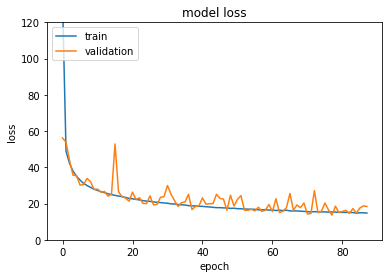

In [23]:
history = load_history(history_path)
plot_loss_curves(history, output_path, y_lim=[0, 120])

Train set:
MSE: 13.13
RMSE: 3.62
CMAPSS score: 1.27

Test set:
MSE: 68.77
RMSE: 8.29
CMAPSS score: 1.84



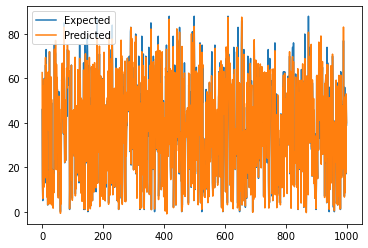

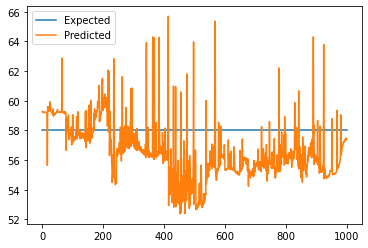

In [24]:
loaded_model = load_model(model_path)
model_evaluation(loaded_model, x_test_final, y_test, x_train_final, y_train)